<a href="https://colab.research.google.com/github/soumyajoykundu/RRR-3D-Reconstruction-BA/blob/main/CV2025_RRR__SK%26CB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **CV Project Work**
Team Members:
* Soumyajoy Kundu -- MDS202349
* Chandranath Bhattacharya -- MDS202318



**$$\text{Reprojection, Reconstruction, Realization :
Refining Multi-View 3D Geometry through Bundle Adjustment}$$**

 **$$\text{[ Code Implementation ]}$$**

### Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set folder path
folder_path = "/content/drive/My Drive/image"

In [ ]:
# Verify files in the folder
print("Files in the folder:", os.listdir(folder_path))

Files in the folder: ['image0.PNG', 'image1.PNG', 'image2.PNG', 'calib0.txt', 'calib1.txt', 'calib2.txt']


### Input Images
* Three images are taken as an input
* Different views of the same scene

In [ ]:
# Load images in RGB
image0_path = os.path.join(folder_path, "image0.PNG")
image1_path = os.path.join(folder_path, "image1.PNG")
image2_path = os.path.join(folder_path, "image2.PNG")

image0 = cv2.imread(image0_path)
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Convert from BGR to RGB
image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

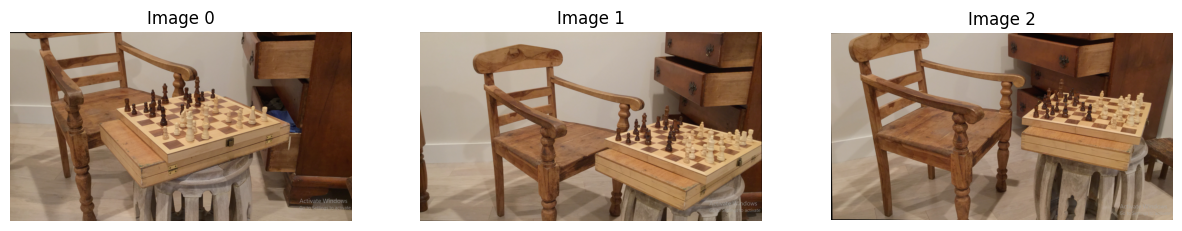

In [ ]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each image in a separate subplot
axes[0].imshow(image0)  # No need for cmap='gray' anymore
axes[0].set_title('Image 0')
axes[0].axis('off')

axes[1].imshow(image1)
axes[1].set_title('Image 1')
axes[1].axis('off')

axes[2].imshow(image2)
axes[2].set_title('Image 2')
axes[2].axis('off')

plt.show()

In [ ]:
image0 = cv2.imread(image0_path, cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

### Defining Uncalibrated Cameras [Optional]
* Preview of `calib0.txt`

```
cam0=[1758.23 0 953.34; 0 1758.23 552.29; 0 0 1]
cam1=[1758.23 0 953.34; 0 1758.23 552.29; 0 0 1]
doffs=0
baseline=111.53
width=1920
height=1080
ndisp=290
vmin=75
vmax=262
```
* This step can be automated and the camera paramteres can be optimised but due to compute power we had the data so we used it.

In [ ]:
def load_camera_parameters(calib_file):
    """
    Loads camera parameters from a calibration file.

    Parameters:
        calib_file (str): Path to the calibration file.

    Returns:
        dict: Dictionary containing camera matrices and other parameters.
    """
    params = {}
    with open(calib_file, "r") as f:
        for line in f:
            if "=" in line:
                key, value = line.strip().split("=")
                key = key.strip()
                value = value.strip()
                if key in ["cam0", "cam1", "cam2"]:
                    values = [float(x) for x in value.replace("[", "").replace("]", "").replace(";", " ").split()]
                    params[key] = np.array(values).reshape(3, 3)
                else:
                    params[key] = float(value) if "." in value else int(value)
    return params

In [ ]:
params0 = load_camera_parameters(os.path.join(folder_path, "calib0.txt"))
params1 = load_camera_parameters(os.path.join(folder_path, "calib1.txt"))
params2 = load_camera_parameters(os.path.join(folder_path, "calib2.txt"))

In [ ]:
K0 = params0["cam0"]
K1 = params1["cam1"]
K2 = params2["cam1"]

In [ ]:
print("Intrinsic Matrix (Image 0):\n", K0)
print("Intrinsic Matrix (Image 1):\n", K1)
print("Intrinsic Matrix (Image 2):\n", K2)

Intrinsic Matrix (Image 0):
 [[1.75823e+03 0.00000e+00 9.53340e+02]
 [0.00000e+00 1.75823e+03 5.52290e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Intrinsic Matrix (Image 1):
 [[1.75823e+03 0.00000e+00 8.72360e+02]
 [0.00000e+00 1.75823e+03 5.52320e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
Intrinsic Matrix (Image 2):
 [[1.75823e+03 0.00000e+00 8.29150e+02]
 [0.00000e+00 1.75823e+03 5.52780e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


### Steps

#### 1. Feature Detection
* SIFT :  Scale Invariant Feature Transform
* Extracting key points to match across different view images

In [ ]:
sift = cv2.SIFT_create()
kp0, desc0 = sift.detectAndCompute(image0, None)
kp1, desc1 = sift.detectAndCompute(image1, None)
kp2, desc2 = sift.detectAndCompute(image2, None)

#### 2. Feature Matching

##### FLANN
 * Fast Library for Approximate Nearest Neighbors
 * Quickly find similar feature points across images.
 * It speeds up matching by approximating nearest neighbors, making it ideal for large datasets (e.g., SIFT/SURF/ORB features).

In [ ]:
flann = cv2.FlannBasedMatcher()
matches01 = flann.knnMatch(desc0, desc1, k=2)
matches12 = flann.knnMatch(desc1, desc2, k=2)

##### Lowe's Ratio Test
* A simple but effective method to filter unreliable feature matches by comparing the quality of the best and second-best matches for each feature point.

In [ ]:
# Lowe's ratio test
good_matches01 = [m for m, n in matches01 if m.distance < 0.7 * n.distance]
good_matches12 = [m for m, n in matches12 if m.distance < 0.7 * n.distance]

In [ ]:
# Extract matched keypoints
pts0_01 = np.float32([kp0[m.queryIdx].pt for m in good_matches01])
pts1_01 = np.float32([kp1[m.trainIdx].pt for m in good_matches01])
pts1_12 = np.float32([kp1[m.queryIdx].pt for m in good_matches12])
pts2_12 = np.float32([kp2[m.trainIdx].pt for m in good_matches12])

In [ ]:
def find_triplet_matches(matches01, matches12):
    """
    Find consistent feature correspondences across three images.

    Given matches between image 0 and 1, and matches between image 1 and 2,
    this function finds triplets of matching keypoints across all three images.

    Parameters:
        matches01 (list): List of matches between image 0 and 1.
        matches12 (list): List of matches between image 1 and 2.

    Returns:
        list of tuples: Each tuple is (idx0, idx1, idx2) indicating corresponding
                        keypoints across images 0, 1, and 2.
    """
    triplets = []
    for m01 in matches01:
        idx0 = m01[0].queryIdx
        idx1 = m01[0].trainIdx
        for m12 in matches12:
            if m12[0].queryIdx == idx1:
                idx2 = m12[0].trainIdx
                triplets.append((idx0, idx1, idx2))
                break
    return triplets

In [ ]:
triplets = find_triplet_matches(matches01, matches12)

In [ ]:
# Collect 2D points for triplets
points2d = []
points3d_indices = []
for idx0, idx1, idx2 in triplets:
    points2d.append([kp0[idx0].pt, kp1[idx1].pt, kp2[idx2].pt])
    points3d_indices.append(len(points3d_indices))

In [ ]:
points2d = np.array(points2d)  # Shape: (n_triplets, 3, 2)

#### 3. Epipolar Geometry & Trianguation

In [ ]:
def estimate_pose(pts1, pts2, K1, K2):
    """
    Estimate relative camera pose (rotation and translation) from point correspondences.

    This function computes the Essential matrix using point correspondences between two images
    and then recovers the relative camera pose (R, t) from it.

    Parameters:
        pts1 (ndarray): Matched keypoints from the first image (Nx2).
        pts2 (ndarray): Matched keypoints from the second image (Nx2).
        K1 (ndarray): Intrinsic matrix of the first camera (3x3).
        K2 (ndarray): Intrinsic matrix of the second camera (3x3).

    Returns:
        R (ndarray): Relative rotation matrix (3x3).
        t (ndarray): Relative translation vector (3x1).
        mask (ndarray): Mask of inliers used in estimation.
    """
    E, mask = cv2.findEssentialMat(pts1, pts2, K1, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K1, mask=mask)
    return R, t, mask

In [ ]:
# Pose for camera 1 relative to camera 0
R1, t1, mask01 = estimate_pose(pts0_01, pts1_01, K0, K1)

# Pose for camera 2 relative to camera 1
R2_1, t2_1, mask12 = estimate_pose(pts1_12, pts2_12, K1, K2)

# Compute camera 2 pose relative to camera 0
R2 = R2_1 @ R1
t2 = t2_1 + R2_1 @ t1

In [ ]:
# Projection matrices
P0 = K0 @ np.hstack((np.eye(3), np.zeros((3, 1))))
P1 = K1 @ np.hstack((R1, t1))
P2 = K2 @ np.hstack((R2, t2))

* Using Triangulation to initially estimate the position of 3D points

In [ ]:
# Initial triangulation
points3d = []
for i, (p0, p1, p2) in enumerate(points2d):

    # Triangulate using first two views
    pts_4d = cv2.triangulatePoints(P0, P1, np.array([p0]).T, np.array([p1]).T)
    pts_3d = (pts_4d[:3] / pts_4d[3]).T[0]
    points3d.append(pts_3d)

points3d = np.array(points3d)

#### 4. Bundle Adjustment

In [ ]:
def project(points3d, K, R, t):
    """
    Project 3D points into 2D image coordinates using camera intrinsics and extrinsics.

    This function transforms 3D points from world coordinates into the image plane using
    the camera projection matrix formed from intrinsic matrix K and extrinsic parameters R and t.

    Parameters:
        points3d (ndarray): Array of 3D points of shape (N, 3).
        K (ndarray): Camera intrinsic matrix of shape (3, 3).
        R (ndarray): Rotation matrix of shape (3, 3).
        t (ndarray): Translation vector of shape (3, 1).

    Returns:
        points2d (ndarray): Projected 2D points of shape (N, 2).
    """
    P = K @ np.hstack((R, t))  # Projection matrix
    points3d_hom = np.hstack((points3d, np.ones((points3d.shape[0], 1))))  # Convert to homogeneous coords
    points2d_hom = (P @ points3d_hom.T).T  # Apply projection
    points2d = points2d_hom[:, :2] / points2d_hom[:, 2:3]  # Normalize by depth
    return points2d

In [ ]:
def rotation_to_angle_axis(R):
    """
    Convert a rotation matrix to an angle-axis representation (Rodrigues vector).

    Parameters:
        R (ndarray): A 3x3 rotation matrix.

    Returns:
        w (ndarray): A 3D vector representing the axis of rotation multiplied by the rotation angle (in radians).
                     If the rotation is negligible, returns a zero vector.
    """
    theta = np.arccos((np.trace(R) - 1) / 2)
    if abs(theta) < 1e-6:
        return np.zeros(3)

    # Compute the rotation axis
    w = (theta / (2 * np.sin(theta))) * np.array([
        R[2, 1] - R[1, 2],
        R[0, 2] - R[2, 0],
        R[1, 0] - R[0, 1]
    ])
    return w

In [ ]:
def angle_axis_to_rotation(w):
    """
    Convert an angle-axis representation (Rodrigues vector) to a rotation matrix.

    Parameters:
        w (ndarray): A 3D vector representing the axis of rotation multiplied by the rotation angle (in radians).

    Returns:
        R (ndarray): A 3x3 rotation matrix corresponding to the rotation defined by the input vector.
    """
    theta = np.linalg.norm(w)
    if abs(theta) < 1e-6:
        return np.eye(3)

    # Normalize the axis
    w = w / theta

    # Skew-symmetric matrix of the vector w
    wx = np.array([
        [0, -w[2], w[1]],
        [w[2], 0, -w[0]],
        [-w[1], w[0], 0]
    ])

    # Rodrigues' rotation formula
    R = np.eye(3) + np.sin(theta) * wx + (1 - np.cos(theta)) * (wx @ wx)
    return R

In [ ]:
from scipy.sparse import lil_matrix
import time

def bundle_adjustment_residuals(params, points2d, n_cameras, n_points, camera_indices, point_indices):
    """
    Compute residuals for bundle adjustment.

    Parameters:
        params (ndarray): Flattened array containing camera parameters (angle-axis + translation) and 3D point coordinates.
        points2d (ndarray): Observed 2D points of shape (n_points, n_cameras, 2).
        n_cameras (int): Number of cameras.
        n_points (int): Number of 3D points.
        camera_indices (array): Array of camera indices for each observation.
        point_indices (array): Array of point indices for each observation.

    Returns:
        residuals (ndarray): Flattened residuals array between projected and observed 2D points.
    """
    # Extract and reshape camera parameters and 3D points
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))  # angle-axis (3) + translation (3)
    points3d = params[n_cameras * 6:].reshape((n_points, 3))

    residuals = []
    for cam_idx, point_idx in zip(camera_indices, point_indices):
        angle_axis = camera_params[cam_idx, :3]
        t = camera_params[cam_idx, 3:]
        K = [K0, K1, K2][cam_idx]  # Use correct intrinsic matrix per camera
        R = angle_axis_to_rotation(angle_axis)
        projected = project(points3d[point_idx:point_idx+1], K, R, t.reshape(3, 1))

        # Residual is the difference between the projected and observed 2D point
        residuals.append(projected[0] - points2d[point_idx, cam_idx])

    return np.concatenate(residuals)

In [ ]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    """
    Create a sparsity matrix for the Jacobian in bundle adjustment.

    Parameters:
        n_cameras (int): Number of cameras.
        n_points (int): Number of 3D points.
        camera_indices (array-like): Indices of cameras for each observation.
        point_indices (array-like): Indices of points for each observation.

    Returns:
        A (scipy.sparse.lil_matrix): Sparse matrix of shape (2 * n_observations, n_cameras*6 + n_points*3)
                                     indicating which parameters affect each residual.
    """
    from scipy.sparse import lil_matrix

    m = len(camera_indices) * 2  # Each observation contributes 2 residuals (x and y)
    n = n_cameras * 6 + n_points * 3  # 6 params per camera, 3 per 3D point
    A = lil_matrix((m, n), dtype=int)

    for i, (cam_idx, point_idx) in enumerate(zip(camera_indices, point_indices)):
        # Set camera parameter block (6 values)
        A[2 * i:2 * i + 2, cam_idx * 6:cam_idx * 6 + 6] = 1
        # Set point parameter block (3 values)
        A[2 * i:2 * i + 2, n_cameras * 6 + point_idx * 3:n_cameras * 6 + point_idx * 3 + 3] = 1

    return A

In [ ]:
n_cameras = 3
n_points = points3d.shape[0]

camera_indices = np.array([cam_idx for point_idx in range(n_points) for cam_idx in range(n_cameras)])
point_indices = np.array([point_idx for point_idx in range(n_points) for cam_idx in range(n_cameras)])
sparsity = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [ ]:
# Camera parameters: [rotation (angle-axis), translation]
camera_params = np.zeros((n_cameras, 6))

# Initialize with estimated values
camera_params[0, 3:] = np.zeros(3)  # Camera 0 at origin
camera_params[1, 3:] = t1.flatten()
camera_params[2, 3:] = t2.flatten()

# Flatten all parameters into a single vector
params = np.concatenate([camera_params.flatten(), points3d.flatten()])

# Convert initial rotations to angle-axis representation
camera_params[0, :3] = rotation_to_angle_axis(np.eye(3))
camera_params[1, :3] = rotation_to_angle_axis(R1)
camera_params[2, :3] = rotation_to_angle_axis(R2)

start_time = time.time()
result = least_squares(
    bundle_adjustment_residuals,
    params,
    jac_sparsity=sparsity,
    args=(points2d, n_cameras, n_points, camera_indices, point_indices),
    method='trf',
    ftol=1e-8,
    xtol=1e-8,
    max_nfev=50,
    verbose=2
)
end_time = time.time()
print(f"Bundle Adjustment Time: {end_time - start_time:.2f} seconds")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.4827e+08                                    7.51e+08    
       1              3         2.1207e+08      6.36e+08       3.82e+00       5.45e+08    
       2              4         9.7670e+07      1.14e+08       2.97e+00       9.34e+07    
       3              6         8.5410e+07      1.23e+07       1.91e+00       5.08e+07    
       4              7         8.1131e+07      4.28e+06       3.82e+00       3.42e+09    
       5              9         7.2844e+07      8.29e+06       5.93e-01       9.57e+08    
       6             10         6.9617e+07      3.23e+06       1.12e+00       4.67e+08    
       7             11         6.6066e+07      3.55e+06       1.19e+00       5.09e+08    
       8             12         6.4516e+07      1.55e+06       2.37e+00       7.73e+07    
       9             14         6.3879e+07      6.37e+05       1.19e+00       1.79e+08    

In [ ]:
# Extract optimized parameters
optimized_params = result.x
camera_params_opt = optimized_params[:n_cameras * 6].reshape((n_cameras, 6))
points3d_opt = optimized_params[n_cameras * 6:].reshape((n_points, 3))

In [ ]:
# Recompute projection matrices
R0_opt = angle_axis_to_rotation(camera_params_opt[0, :3])
t0_opt = camera_params_opt[0, 3:].reshape(3, 1)
R1_opt = angle_axis_to_rotation(camera_params_opt[1, :3])
t1_opt = camera_params_opt[1, 3:].reshape(3, 1)
R2_opt = angle_axis_to_rotation(camera_params_opt[2, :3])
t2_opt = camera_params_opt[2, 3:].reshape(3, 1)

P0_opt = K0 @ np.hstack((R0_opt, t0_opt))
P1_opt = K1 @ np.hstack((R1_opt, t1_opt))
P2_opt = K2 @ np.hstack((R2_opt, t2_opt))

In [ ]:
def compute_reprojection_error(points3d, points2d, Ps, Ks):
    """
    Compute the mean reprojection error between 3D points and their 2D projections across all cameras.

    Parameters:
        points3d (ndarray): 3D points in space of shape (n_points, 3).
        points2d (ndarray): 2D points in image space of shape (n_points, n_cameras, 2).
        Ps (list): List of camera projection matrices (each of shape (3, 4)).
        Ks (list): List of camera intrinsic matrices (each of shape (3, 3)).

    Returns:
        float: Mean reprojection error.
    """
    error = []
    for i, (p2d, P, K) in enumerate(zip(points2d.T, Ps, Ks)):
        # Project 3D points onto the 2D image plane using the camera's projection matrix and intrinsic matrix
        projected = project(points3d, K, P[:, :3], P[:, 3:4])

        # Reshape p2d to (num_points, 2) to match projected shape
        p2d = p2d.T[:, :2]  # Select the first 2 columns (x, y) and transpose

        # Compute the mean L2 norm of the reprojection error for the current camera
        error.append(np.mean(np.linalg.norm(projected - p2d, axis=1)))

    # Return the mean reprojection error across all cameras
    return np.mean(error)

In [ ]:
Ps = [P0_opt, P1_opt, P2_opt]
Ks = [K0, K1, K2]
reproj_error = compute_reprojection_error(points3d_opt, points2d, Ps, Ks)
print(f"Reprojection Error: {reproj_error:.4f} pixels")

Reprojection Error: 1300809.3286 pixels


#### 5. Visualising the 3D point cloud

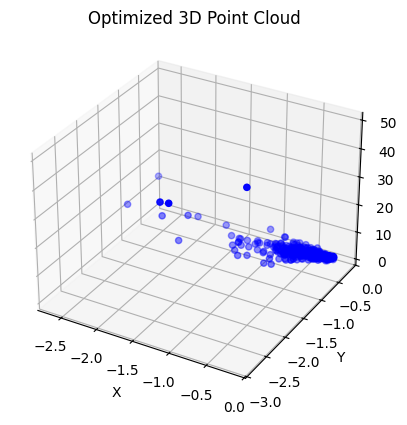

In [ ]:
# Visualize 3D points
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3d_opt[:, 0], points3d_opt[:, 1], points3d_opt[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Optimized 3D Point Cloud')
plt.show()

In [ ]:
# Project optimized 3D points to 2D for each camera
projected_points = []
for P in [P0_opt, P1_opt, P2_opt]:
    points3d_hom = np.hstack((points3d_opt, np.ones((n_points, 1))))
    points2d_hom = (P @ points3d_hom.T).T
    points2d_proj = points2d_hom[:, :2] / points2d_hom[:, 2:3]
    projected_points.append(points2d_proj)

projected_points = np.array(projected_points).transpose(1, 0, 2)  # Shape: (n_points, 3, 2)

In [ ]:
# Compute reprojection errors per point
reproj_errors = np.linalg.norm(projected_points - points2d, axis=2)  # Shape: (n_points, 3)
mean_errors_per_camera = np.mean(reproj_errors, axis=0)
mean_error_overall = np.mean(reproj_errors)

Reprojection Errors (pixels):
Camera 0: Mean = 113.3626, Max = 503.1029
Camera 1: Mean = 162.3246, Max = 842.6586
Camera 2: Mean = 117.7991, Max = 670.8991
Overall Mean Reprojection Error: 131.1621 pixels


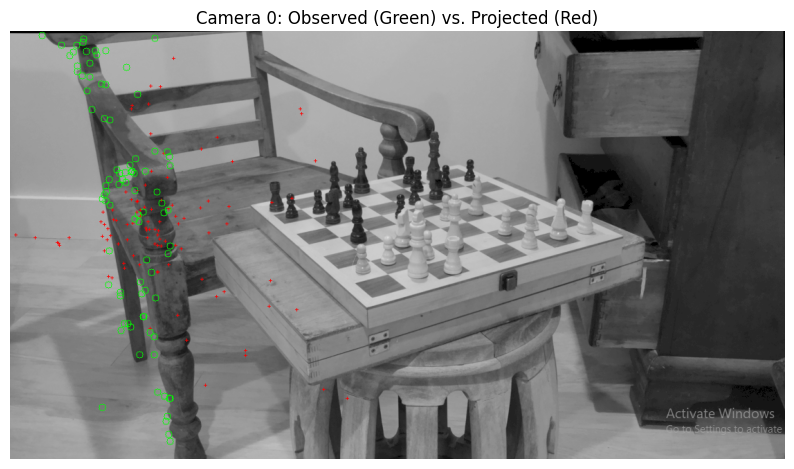

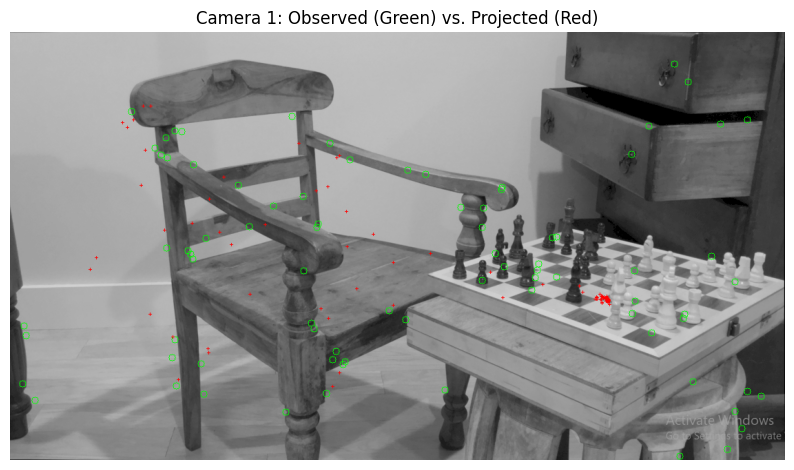

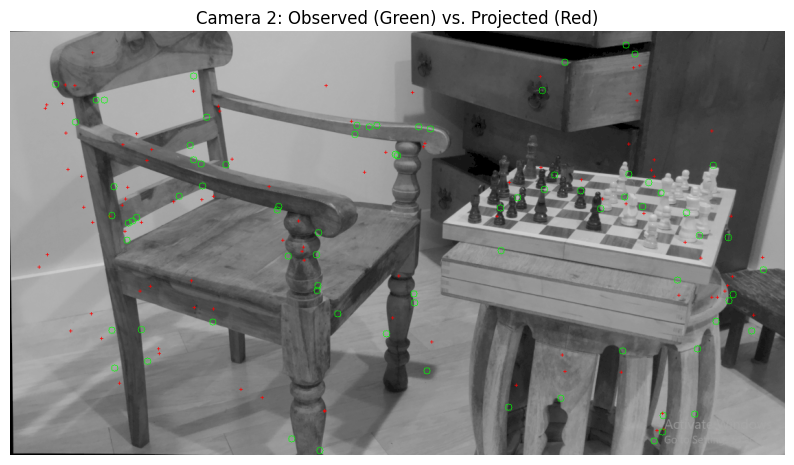

In [ ]:
# Print error summary
print("Reprojection Errors (pixels):")
for cam_idx, mean_err in enumerate(mean_errors_per_camera):
    print(f"Camera {cam_idx}: Mean = {mean_err:.4f}, Max = {np.max(reproj_errors[:, cam_idx]):.4f}")
print(f"Overall Mean Reprojection Error: {mean_error_overall:.4f} pixels")

# Visualize observed vs. projected points on images
def plot_points_on_image(image, observed_pts, projected_pts, title, max_points=100):
    """
    Visualizes the observed and projected points on an image. Observed points are shown as green circles
    and projected points are shown as red crosses.

    Parameters:
        image (ndarray): The image on which points will be plotted (grayscale).
        observed_pts (ndarray): The observed 2D points in the image, shape (n_points, 2).
        projected_pts (ndarray): The projected 2D points from 3D reconstruction, shape (n_points, 2).
        title (str): The title for the plot.
        max_points (int): Maximum number of points to visualize (default is 100).

    Returns:
        None
    """
    # Convert grayscale to RGB for colored points
    img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    h, w = img_rgb.shape[:2]

    # Limit number of points to avoid clutter
    indices = np.arange(min(len(observed_pts), max_points))

    for idx in indices:
        # Observed points (green circles)
        obs_x, obs_y = int(observed_pts[idx, 0]), int(observed_pts[idx, 1])
        if 0 <= obs_x < w and 0 <= obs_y < h:
            cv2.circle(img_rgb, (obs_x, obs_y), 5, (0, 255, 0), 1)

        # Projected points (red crosses)
        proj_x, proj_y = int(projected_pts[idx, 0]), int(projected_pts[idx, 1])
        if 0 <= proj_x < w and 0 <= proj_y < h:
            cv2.drawMarker(img_rgb, (proj_x, proj_y), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1)

    # Plot the image with points
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Plot for each camera
for cam_idx, (img, title) in enumerate([
    (image0, "Camera 0: Observed (Green) vs. Projected (Red)"),
    (image1, "Camera 1: Observed (Green) vs. Projected (Red)"),
    (image2, "Camera 2: Observed (Green) vs. Projected (Red)")
]):
    plot_points_on_image(img, points2d[:, cam_idx], projected_points[:, cam_idx], title)

---
                                                         
                                                          
                                                           
                                                            
                                                             Thank You :)